## Multi-year UNSEEN ##

Test notebook for figuring out the methodology for exploring how to create a synthetic event set for multi-year wind droughts.

In [1]:
# Import local modules
import sys
import os
import glob

# Import third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import iris

In [2]:
# Import my modules
import dictionaries as dic

### Exploring gridboxes ###

Checking that the gridboxes are where we expect them to be

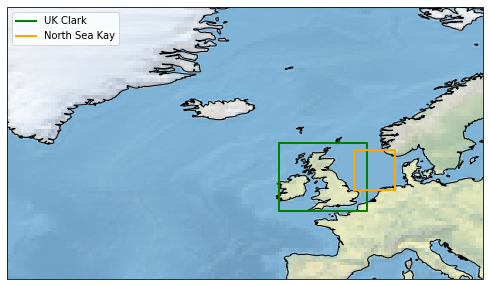

In [3]:
# First, we want to visualise th gridboxes which we might want to use
# The UK grid box or the north sea grid box

# Set up the projection
projection = ccrs.PlateCarree(central_longitude=0)

# Plot the differences between the two gridboxes
# Set up the figure
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=projection)

# # Include the stock image and coastlines
ax.stock_img()
ax.coastlines()

# Extract the lat and lon data for the UK box
lon1_uk, lon2_uk = dic.uk_grid['lon1'], dic.uk_grid['lon2']
lat1_uk, lat2_uk = dic.uk_grid['lat1'], dic.uk_grid['lat2']

# Extract the lat and lon data for the North Sea box
lon1_ns, lon2_ns = dic.north_sea_kay['lon1'], dic.north_sea_kay['lon2']
lat1_ns, lat2_ns = dic.north_sea_kay['lat1'], dic.north_sea_kay['lat2']

# Plot these boxes
ax.plot([lon1_uk, lon2_uk, lon2_uk, lon1_uk, lon1_uk],
        [lat1_uk, lat1_uk, lat2_uk, lat2_uk, lat1_uk],
        color='green', linewidth=2, transform=projection, label="UK Clark")

# Plot these boxes
ax.plot([lon1_ns, lon2_ns, lon2_ns, lon1_ns, lon1_ns],
        [lat1_ns, lat1_ns, lat2_ns, lat2_ns, lat1_ns],
        color='orange', linewidth=2, transform=projection, label="North Sea Kay")

# Zoom in on the region
ax.set_extent([-50, 20, 40, 80], crs=projection)

# Create a legend
ax.legend(loc = 'upper left')

# show the plot
plt.show()

### Choosing time windows ###

We need to define the time period over which we are looking for wind droughts. Here are three we might consider:

* 1 year (12 months Dec-Nov)
* 3 years (36 months Dec-Nov)
* 5 years (60 months Dec-Nov)

In this first example of 1 year, for 1960 there will be 11 total 12 month time series (DJFMAMJJASON):

* 1 will be the truth (from ERA5) - the weather which actually occurred.
* 10 will be from the decadal prediction system (in this case DePreSys with 10 ensemble members).
    * Here we are assuming November initialisation.

### Extracting the data ###

Model data in this example from HadGEM3-GC31-MM.

Obs data in this example from ERA5.

In [4]:
# Set up the parameters for extraction
model_var = "sfcWind"
obs_var = "si10"
test_model = "HadGEM3-GC31-MM"
experiment = "dcppA-hindcast"

In [5]:
# Load the observations data as an iris cube for the si10 variable
# Deal with the expver variables
obs = xr.open_mfdataset(dic.obs_path, combine='by_coords', parallel=True)[obs_var]

# Combine the two expver variables
obs = obs.sel(expver=1).combine_first(obs.sel(expver=5))

# Convert to an iris cube
obs = obs.to_iris()

print(obs)

10 metre wind speed / (m s**-1)     (time: 775; latitude: 721; longitude: 1440)
    Dimension coordinates:
        time                             x              -               -
        latitude                         -              x               -
        longitude                        -              -               x


In [27]:
# Load one example of the model data as an iris cube
init_year = 1960
realisation = 1

# Form the directory containing the data
hadgem_dir = os.path.join(dic.gws_base, experiment, "data",
                          model_var, test_model, "merged_files")

# List the files in the directory
files = glob.glob(os.path.join(hadgem_dir, "*.nc"))

# Print the files
print(files)

# Find the file constaining fs{init_year}r{realisation}
file = [f for f in files if f"s{init_year}" in f and f"r{realisation}i" in f][0]

# Print rthe file
print(file)

# Load the file as an iris cube
hadgem_example = iris.load_cube(file, model_var)

# Print the cube
print(hadgem_example)

['/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1p1f2_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r3i1p1f2_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r4i1p1f2_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'sfcWind'
  warnings.warn(


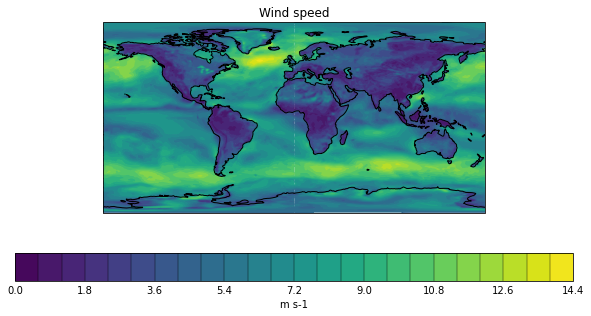

In [12]:
import iris.quickplot as qplt

# Quick plot of the data
# Set up the figure
fig = plt.figure(figsize=(10, 5))
qplt.contourf(hadgem_example[0,:,:], 25)
plt.gca().coastlines()


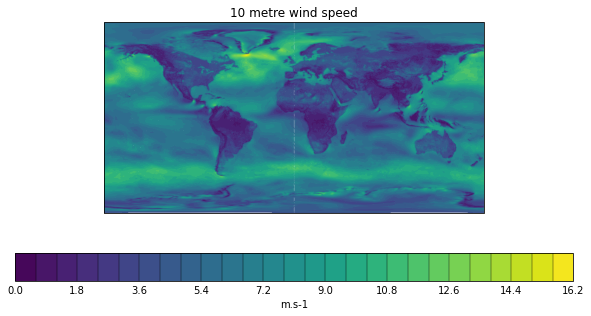

In [14]:
# Same but for the observations
# Set up the figure
projection = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=projection)
qplt.contourf(obs[0,:,:], 25)

In [20]:
# Importlib reload
import importlib

# Reload the dictionaries
importlib.reload(dic)

<module 'dictionaries' from '/home/users/benhutch/multi_year_unseen/dictionaries.py'>

In [21]:
print(dic.obs_path)

/home/users/benhutch/ERA5/surface_wind_ERA5.nc


In [22]:
# Import cdo
from cdo import *
cdo = Cdo()

# Give up on Iris regridding, just use cdo in python instead
target_grid = file # This is the example HadGEM file
input_obs = dic.obs_path # for surface wind
output_obs = "/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc"

# Regrid the ERA5 data to the HadGEM grid
cdo.remapbil(target_grid, input=input_obs, output=output_obs)

'/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc'

In [23]:
# Importlib reload
import importlib

# Reload the dictionaries
importlib.reload(dic)

<module 'dictionaries' from '/home/users/benhutch/multi_year_unseen/dictionaries.py'>

In [25]:
# Load the regridded observations data as an iris cube for the si10 variable
# Deal with the expver variables
obs_regrid = xr.open_mfdataset(dic.regrid_hadgem_obs_path, combine='by_coords', parallel=True)[obs_var]

# Combine the two expver variables
obs_regrid = obs_regrid.sel(expver=1).combine_first(obs_regrid.sel(expver=5))

# Convert to an iris cube
obs_regrid = obs_regrid.to_iris()

# Print the cube
print(obs_regrid)

10 metre wind speed / (m s**-1)     (time: 775; latitude: 324; longitude: 432)
    Dimension coordinates:
        time                             x              -               -
        latitude                         -              x               -
        longitude                        -              -               x


Text(0.5, 1.0, 'ERA5')

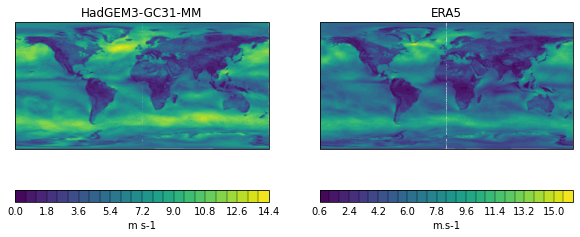

In [29]:
# Side by side comparison of the two
# Set up the figure
projection = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=(10, 5))

# Plot the HadGEM data
ax = fig.add_subplot(1, 2, 1, projection=projection)
qplt.contourf(hadgem_example[0,:,:], 25)
ax.set_title("HadGEM3-GC31-MM")

# Plot the ERA5 data
ax = fig.add_subplot(1, 2, 2, projection=projection)
qplt.contourf(obs_regrid[0,:,:], 25)
ax.set_title("ERA5")

Regridding complete (for HadGEM at least), now to process the data.